<a href="https://colab.research.google.com/github/Colsai/Covid-Visualizations-And-Trends/blob/main/covid_visualizations_county.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# US Covid Trends and Predictions 
<blockquote> Scott Hirabayashi | (Sourced from NYT's Github) | 2020  </blockquote>

- Visualizations and Basic Information about trends in cases, etc.  
- Included- A Basic ML Model to Estimate Cases and Deaths  
- Focus on USA/ MD / VA  
- NYT Datasets Used  


In [91]:
#Datetime To Convert Dates
from datetime import datetime

#Import Packages for Data
import pandas as pd
import numpy as np
import scipy as sci
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import statistics

In [92]:
#Seaborn/Matplotlib basic stats
sns.set(style="ticks")
plt.style.use('seaborn-white')

In [93]:
#Cases by day from beginning (US). This is a large dataframe, so it make take a bit to load.

#USA Data will be the dataframe for national data
site = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
states_df = pd.read_csv(site)

In [94]:
#Head of the data
states_df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [95]:
#Tail of the data
states_df.tail()

,date,county,state,fips,cases,deaths
823150,2020-12-12,Sweetwater,Wyoming,56037.0,2384,14.0
823151,2020-12-12,Teton,Wyoming,56039.0,1886,2.0
823152,2020-12-12,Uinta,Wyoming,56041.0,1289,7.0
823153,2020-12-12,Washakie,Wyoming,56043.0,628,11.0
823154,2020-12-12,Weston,Wyoming,56045.0,428,2.0


In [96]:
#Sample of the data
states_df.sample(5)

,date,county,state,fips,cases,deaths
212907,2020-06-06,Shelby,Illinois,17173.0,16,1.0
375612,2020-07-27,Perkins,South Dakota,46105.0,4,0.0
354837,2020-07-21,Nemaha,Kansas,20131.0,38,0.0
721122,2020-11-11,Mora,New Mexico,35033.0,19,0.0
444561,2020-08-18,Payette,Idaho,16075.0,468,4.0


In [97]:
#Let's See What We Have...
states_df.describe()

,fips,cases,deaths
count,815368.000000,823155.000000,805876.000000
mean,31244.721646,1677.544492,49.990131
std,16291.372537,8756.741120,443.239243
min,1001.000000,0.000000,0.000000
25%,18181.000000,31.000000,0.000000
50%,29211.000000,188.000000,3.000000
75%,46097.000000,830.000000,18.000000
max,78030.000000,513029.000000,24467.000000


In [98]:
#Shape of the Dataframe
states_df.shape

(823155, 6)

In [99]:
#What are the different types of data?
states_df.dtypes

date       object
county     object
state      object
fips      float64
cases       int64
deaths    float64
dtype: object

In [100]:
#Let's convert the states_df date to datetime, so that it will graph easier. 
states_df['date'] = pd.to_datetime(states_df['date'])

In [101]:
# Drop fips
states_df = states_df.drop(columns = "fips")

In [102]:
#Melt the visualizations into date/county
states_df.melt(id_vars = ["date", "county", "state"])

,date,county,state,variable,value
0,2020-01-21,Snohomish,Washington,cases,1.0
1,2020-01-22,Snohomish,Washington,cases,1.0
2,2020-01-23,Snohomish,Washington,cases,1.0
3,2020-01-24,Cook,Illinois,cases,1.0
4,2020-01-24,Snohomish,Washington,cases,1.0
...,...,...,...,...,...
1646305,2020-12-12,Sweetwater,Wyoming,deaths,14.0
1646306,2020-12-12,Teton,Wyoming,deaths,2.0
1646307,2020-12-12,Uinta,Wyoming,deaths,7.0
1646308,2020-12-12,Washakie,Wyoming,deaths,11.0


In [103]:
#Let's reset the index before we move on
states_df.reset_index(drop = True)

,date,county,state,cases,deaths
0,2020-01-21,Snohomish,Washington,1,0.0
1,2020-01-22,Snohomish,Washington,1,0.0
2,2020-01-23,Snohomish,Washington,1,0.0
3,2020-01-24,Cook,Illinois,1,0.0
4,2020-01-24,Snohomish,Washington,1,0.0
...,...,...,...,...,...
823150,2020-12-12,Sweetwater,Wyoming,2384,14.0
823151,2020-12-12,Teton,Wyoming,1886,2.0
823152,2020-12-12,Uinta,Wyoming,1289,7.0
823153,2020-12-12,Washakie,Wyoming,628,11.0


## Adding some more change functions, to look at the data
- Total Change (Change based on the last day)
- Percent Change (Percent Change based on the last day)

In [104]:
#This is a simple function that returns items based on their change over time. 
def total_change(input_list, rounded_val=2):
    total_list = []
    day_change = 0
    
    for day in input_list:
        try:
              day_change = day - day_before
        except:
              day_before = 0

        total_list.append(day_change)
        day_before = day
    return total_list

In [105]:
#This is a simple function that returns items based on their change over time. 
def percent_change(input_list, rounded_val=2):
    percent_list = []

    for this_year in input_list:
        try:
              pct_increase = ((this_year - last_year) / last_year) * 100
        except:
              pct_increase = 0

        percent_list.append(round(pct_increase,2))
        last_year = this_year

    percent_list = [round(i, rounded_val) for i in percent_list] #This function combines rounding inside of it, since percents are easier to use

    return percent_list

In [106]:
#days after start function
def days_after_start(df):
    days_after = []

    for i in range(1,len(df['date'].to_list()) + 1):
        days_after.append(i)

    df.insert(1,"since_start", days_after)

## Let's look at a specific county to apply the change functions

In [107]:
#Function to insert new cases/new cases pct/new deaths/new deaths pct to a county
def more_statistics(df):
    df.insert(4, "new cases", total_change(df['cases'].to_list()))
    df.insert(5, "cases pct inc", percent_change(df['cases'].to_list()))
    df.insert(7, "new deaths", total_change(df['deaths'].to_list()))
    df.insert(8, "deaths pct inc", percent_change(df['deaths'].to_list()))

    days_after_start(df)

In [108]:
#Let's select Montgomery County First
moco_df = states_df.loc[(states_df['state'] == "Maryland") & (states_df['county'] == "Montgomery")]
moco_df = moco_df.reset_index(drop = True)
more_statistics(moco_df)

In [109]:
moco_df

,date,since_start,county,state,cases,new cases,cases pct inc,deaths,new deaths,deaths pct inc
0,2020-03-05,1,Montgomery,Maryland,3,0,0.00,0.0,0.0,0.00
1,2020-03-06,2,Montgomery,Maryland,3,0,0.00,0.0,0.0,0.00
2,2020-03-07,3,Montgomery,Maryland,3,0,0.00,0.0,0.0,0.00
3,2020-03-08,4,Montgomery,Maryland,4,1,33.33,0.0,0.0,0.00
4,2020-03-09,5,Montgomery,Maryland,4,0,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...
278,2020-12-08,279,Montgomery,Maryland,36895,402,1.10,993.0,3.0,0.30
279,2020-12-09,280,Montgomery,Maryland,37238,343,0.93,1000.0,7.0,0.70
280,2020-12-10,281,Montgomery,Maryland,37782,544,1.46,1002.0,2.0,0.20
281,2020-12-11,282,Montgomery,Maryland,38234,452,1.20,1012.0,10.0,1.00


In [126]:
#pg df
pg_df = states_df.loc[(states_df['state'] == "Maryland") & (states_df['county'] == "Prince George's")]
pg_df = pg_df.reset_index(drop = True)
more_statistics(pg_df)

In [127]:
pg_df.head()

,date,since_start,county,state,cases,new cases,cases pct inc,deaths,new deaths,deaths pct inc
0,2020-03-09,1,Prince George's,Maryland,1,0,0.00,0.0,0.0,0.0
1,2020-03-10,2,Prince George's,Maryland,3,2,200.00,0.0,0.0,0.0
2,2020-03-11,3,Prince George's,Maryland,5,2,66.67,0.0,0.0,0.0
3,2020-03-12,4,Prince George's,Maryland,5,0,0.00,0.0,0.0,0.0
4,2020-03-13,5,Prince George's,Maryland,7,2,40.00,0.0,0.0,0.0


In [111]:
ba_df = states_df.loc[(states_df['state'] == "Maryland") & (states_df['county'] == "Baltimore")]
pg_df = ba_df.reset_index(drop = True)
more_statistics(ba_df)

In [112]:
pg_df.head()

,date,county,state,cases,deaths
0,2020-03-11,Baltimore,Maryland,1,0.0
1,2020-03-12,Baltimore,Maryland,1,0.0
2,2020-03-13,Baltimore,Maryland,2,0.0
3,2020-03-14,Baltimore,Maryland,3,0.0
4,2020-03-15,Baltimore,Maryland,3,0.0


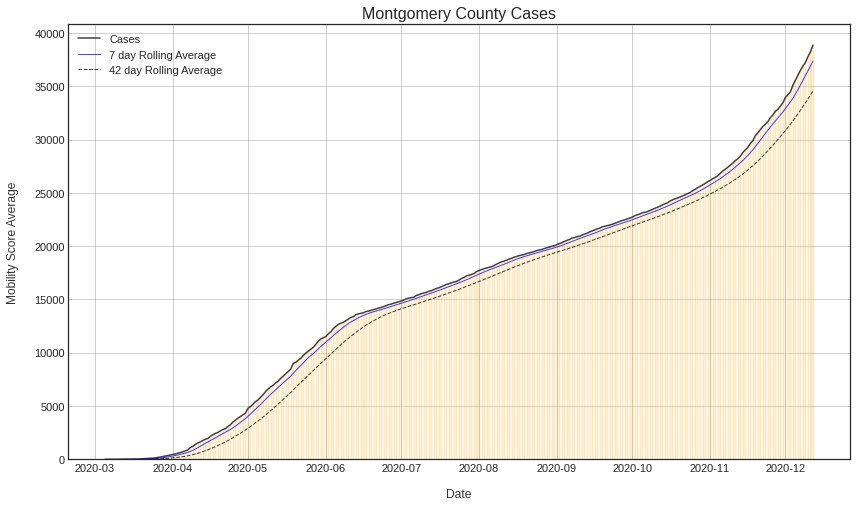

In [113]:
#EDA Basic Plotting for Cases by Date
date = moco_df['date']
co_cases = moco_df['cases']
co_deaths = moco_df['deaths']

fig, ax = plt.subplots(figsize = (14,8))

ax.plot(date, co_cases, '-', alpha = .75, color = 'black', label = f"Cases")
ax.bar(date, co_cases, alpha = .25, color = 'orange')
ax.plot(date, co_cases.rolling(7).mean(), '-', alpha = .75, linewidth = 1, color = 'blue', label = "7 day Rolling Average")
ax.plot(date, co_cases.rolling(21).mean(), '--', alpha = .75, linewidth = 1, color = 'black', label = "42 day Rolling Average")

ax.set_title(f"Montgomery County Cases", fontsize = 16)
ax.grid(which = 'both', color='gray', alpha = .75, linestyle='-', linewidth=.5)
ax.set_xlabel("Date", labelpad=15, fontsize=12, color="#333533");
ax.set_ylabel(f"Mobility Score Average", labelpad=15, fontsize=12, color="#333533")
ax.legend()

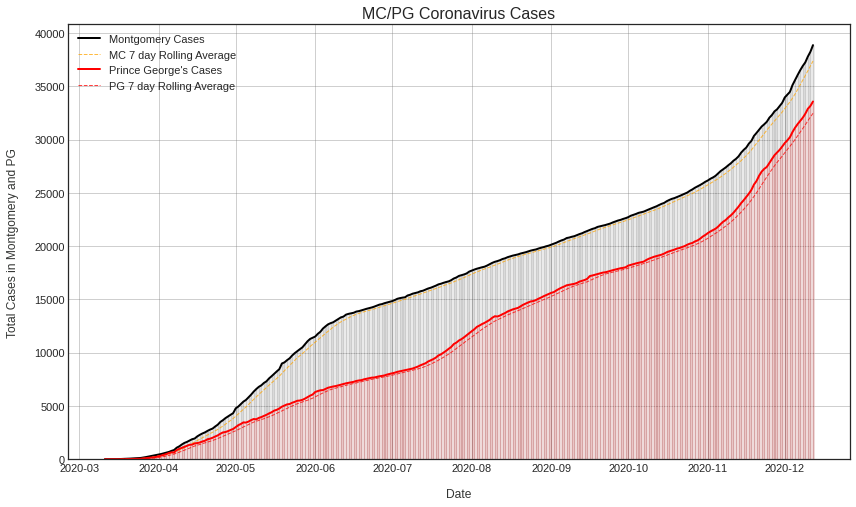

In [118]:
#EDA Basic Plotting for Cases by Date
date = moco_df['date'][6:]
mc_cases = moco_df['cases'][6:]
pg_cases = pg_df['cases']

fig, ax = plt.subplots(figsize = (14,8))

ax.plot(date, mc_cases, '-', alpha = 1, color = 'black', linewidth = 2, label = f"Montgomery Cases")
ax.bar(date, mc_cases, alpha = .2, color = 'black')
ax.plot(date, mc_cases.rolling(7).mean(), '--', alpha = .75, linewidth = 1, color = 'orange', label = "MC 7 day Rolling Average")

ax.plot(date, pg_cases, '-', alpha = 1, color = 'red', linewidth = 2, label = f"Prince George's Cases")
ax.bar(date, pg_cases, alpha = .2, color = 'red')
ax.plot(date, pg_cases.rolling(7).mean(), '--', alpha = .75, linewidth = 1, color = 'red', label = "PG 7 day Rolling Average")

ax.set_title(f"MC/PG Coronavirus Cases", fontsize = 16)
ax.grid(which = 'both', color='gray', alpha = .75, linestyle='-', linewidth=.5)
ax.set_xlabel("Date", labelpad=15, fontsize=12, color="#333533");
ax.set_ylabel(f"Total Cases in Montgomery and PG", labelpad=15, fontsize=12, color="#333533")
ax.legend()

In [ ]:
pg_df.head()

In [ ]:
#EDA Basic Plotting for Cases by Date
date = moco_df['date'][4:]
mc_cases = moco_df['deaths pct inc'][4:]
pg_cases = pg_df['deaths pct inc']

fig, ax = plt.subplots(figsize = (14,8))

ax.plot(date, mc_cases, '-x', alpha = .1, color = 'black', linewidth = 1)
ax.bar(date, mc_cases, alpha = .1, color = 'black')
ax.plot(date, mc_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'black', label = "MC Case Pct Increase (7-day rolling)")

ax.plot(date, pg_cases, '-o', alpha = .1, color = 'maroon', linewidth = 1)
ax.bar(date, pg_cases, alpha = .1, color = 'maroon')
ax.plot(date, pg_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'maroon', label = "PG Case Pct Increase (7-day rolling)")

ax.set_title(f"MC/PG Coronavirus Case Increases, by day (logarithmic)", fontsize = 16)
ax.grid(which = 'both', color='gray', alpha = .75, linestyle='-', linewidth=.5)
ax.set_yscale('log')
ax.set_xlabel("Date", labelpad=15, fontsize=12, color="#333533");
ax.set_ylabel(f"Case Percentages", labelpad=15, fontsize=12, color="#333533")
ax.legend()

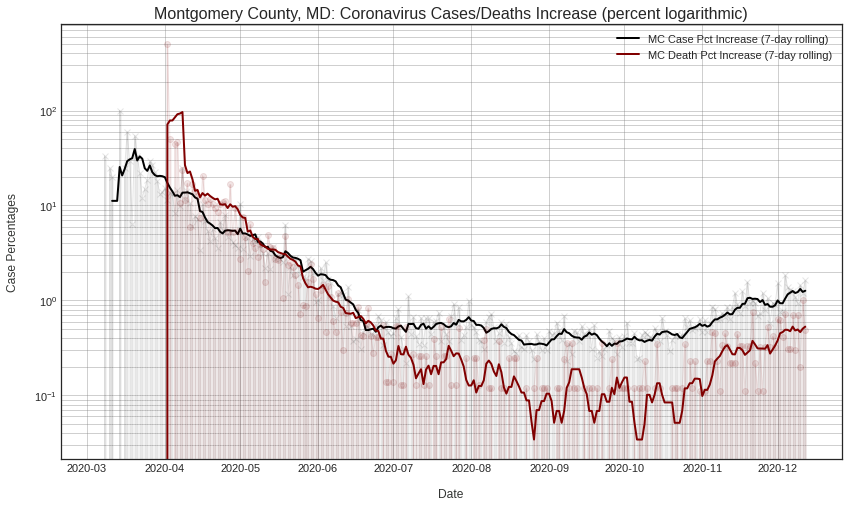

In [119]:
#EDA Basic Plotting for Cases by Date
date = moco_df['date']
mc_cases = moco_df['cases pct inc']
mc_deaths = moco_df['deaths pct inc']

fig, ax = plt.subplots(figsize = (14,8))

ax.plot(date, mc_cases, '-x', alpha = .1, color = 'black', linewidth = 1)
ax.bar(date, mc_cases, alpha = .1, color = 'black')
ax.plot(date, mc_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'black', label = "MC Case Pct Increase (7-day rolling)")

ax.plot(date, mc_deaths, '-o', alpha = .1, color = 'maroon', linewidth = 1)
ax.bar(date, mc_deaths, alpha = .1, color = 'maroon')
ax.plot(date, mc_deaths.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'maroon', label = "MC Death Pct Increase (7-day rolling)")

ax.set_title(f"Montgomery County, MD: Coronavirus Cases/Deaths Increase (percent logarithmic)", fontsize = 16)
ax.grid(which = 'both', color='gray', alpha = .75, linestyle='-', linewidth=.5)
ax.set_yscale('log')
ax.set_xlabel("Date", labelpad=15, fontsize=12, color="#333533");
ax.set_ylabel(f"Case Percentages", labelpad=15, fontsize=12, color="#333533")
ax.legend()

In [134]:
len(moco_df)

283

In [133]:
len(pg_df)

279

In [132]:
len(ba_df)

277

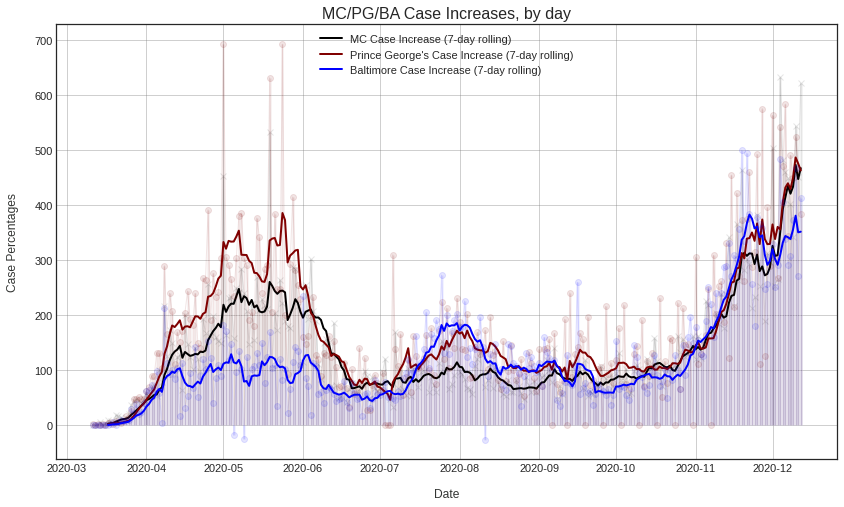

In [143]:
#EDA Basic Plotting for Cases by Date
date = moco_df['date'][6:]
mc_new_cases = moco_df['new cases'][6:]
pg_new_cases = pg_df['new cases'][2:]
ba_new_cases = ba_df['new cases']

fig, ax = plt.subplots(figsize = (14,8))

ax.plot(date, mc_new_cases, '-x', alpha = .1, color = 'black', linewidth = 1)
ax.bar(date, mc_new_cases, alpha = .1, color = 'black')
ax.plot(date, mc_new_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'black', label = "MC Case Increase (7-day rolling)")

ax.plot(date, pg_new_cases, '-o', alpha = .1, color = 'maroon', linewidth = 1)
ax.bar(date, pg_new_cases, alpha = .1, color = 'maroon')
ax.plot(date, pg_new_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'maroon', label = "Prince George's Case Increase (7-day rolling)")

ax.plot(date, ba_new_cases, '-o', alpha = .1, color = 'blue', linewidth = 1)
ax.bar(date, ba_new_cases, alpha = .1, color = 'blue')
ax.plot(date, ba_new_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'blue', label = "Baltimore Case Increase (7-day rolling)")

ax.set_title(f"MC/PG/BA Case Increases, by day", fontsize = 16)
ax.grid(which = 'both', color='gray', alpha = .75, linestyle='-', linewidth=.5)
ax.set_yscale('linear')
ax.set_xlabel("Date", labelpad=15, fontsize=12, color="#333533");
ax.set_ylabel(f"Case Percentages", labelpad=15, fontsize=12, color="#333533")
ax.legend()

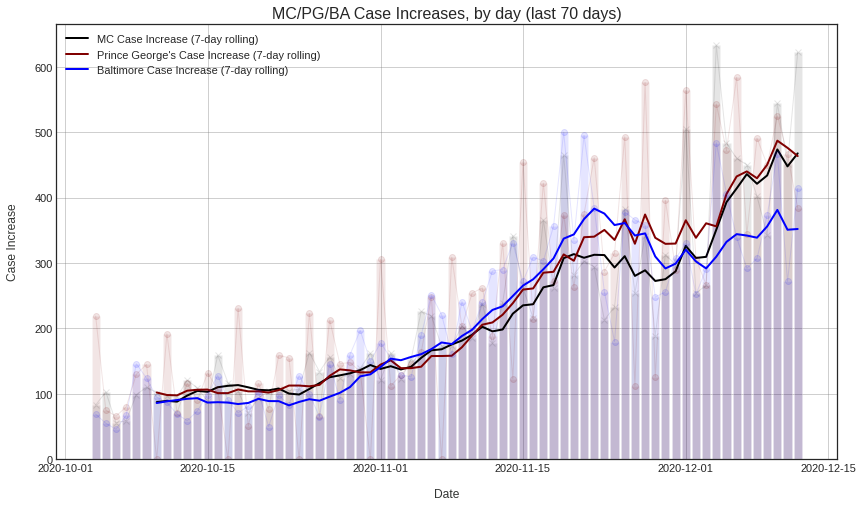

In [153]:
#EDA Basic Plotting for Cases by Date
n = 70 #n number of days

date = moco_df['date'][-n:]
mc_new_cases = moco_df['new cases'][-n:]
pg_new_cases = pg_df['new cases'][-n:]
ba_new_cases = ba_df['new cases'][-n:]

fig, ax = plt.subplots(figsize = (14,8))

ax.plot(date, mc_new_cases, '-x', alpha = .1, color = 'black', linewidth = 1)
ax.bar(date, mc_new_cases, alpha = .1, color = 'black')
ax.plot(date, mc_new_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'black', label = "MC Case Increase (7-day rolling)")

ax.plot(date, pg_new_cases, '-o', alpha = .1, color = 'maroon', linewidth = 1)
ax.bar(date, pg_new_cases, alpha = .1, color = 'maroon')
ax.plot(date, pg_new_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'maroon', label = "Prince George's Case Increase (7-day rolling)")

ax.plot(date, ba_new_cases, '-o', alpha = .1, color = 'blue', linewidth = 1)
ax.bar(date, ba_new_cases, alpha = .1, color = 'blue')
ax.plot(date, ba_new_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'blue', label = "Baltimore Case Increase (7-day rolling)")

ax.set_title(f"MC/PG/BA Case Increases, by day (last {n} days)", fontsize = 16)
ax.grid(which = 'both', color='gray', alpha = .75, linestyle='-', linewidth=.5)
ax.set_yscale('linear')
ax.set_xlabel("Date", labelpad=15, fontsize=12, color="#333533");
ax.set_ylabel(f"Case Increase", labelpad=15, fontsize=12, color="#333533")
ax.legend()

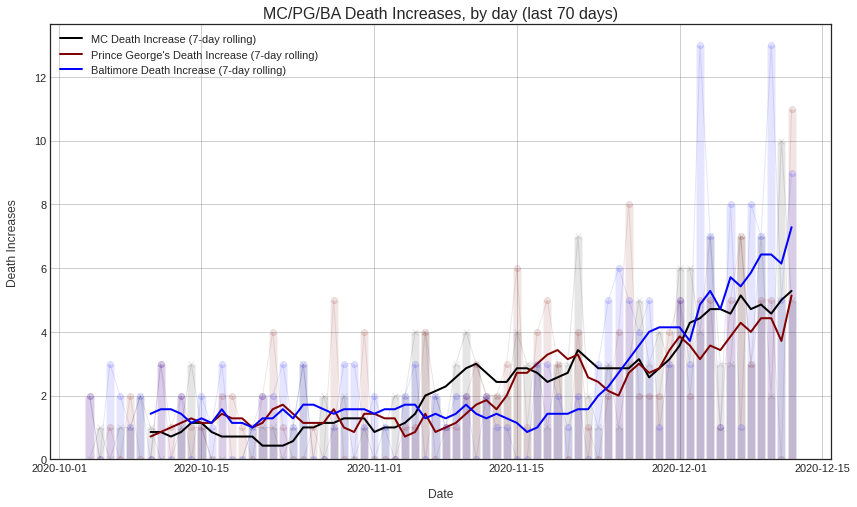

In [154]:
#EDA Basic Plotting for Cases by Date
n = 70 #n number of days

date = moco_df['date'][-n:]
mc_new_cases = moco_df['new deaths'][-n:]
pg_new_cases = pg_df['new deaths'][-n:]
ba_new_cases = ba_df['new deaths'][-n:]

fig, ax = plt.subplots(figsize = (14,8))

ax.plot(date, mc_new_cases, '-x', alpha = .1, color = 'black', linewidth = 1)
ax.bar(date, mc_new_cases, alpha = .1, color = 'black')
ax.plot(date, mc_new_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'black', label = "MC Death Increase (7-day rolling)")

ax.plot(date, pg_new_cases, '-o', alpha = .1, color = 'maroon', linewidth = 1)
ax.bar(date, pg_new_cases, alpha = .1, color = 'maroon')
ax.plot(date, pg_new_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'maroon', label = "Prince George's Death Increase (7-day rolling)")

ax.plot(date, ba_new_cases, '-o', alpha = .1, color = 'blue', linewidth = 1)
ax.bar(date, ba_new_cases, alpha = .1, color = 'blue')
ax.plot(date, ba_new_cases.rolling(7).mean(), '-', alpha = 1, linewidth = 2, color = 'blue', label = "Baltimore Death Increase (7-day rolling)")

ax.set_title(f"MC/PG/BA Death Increases, by day (last {n} days)", fontsize = 16)
ax.grid(which = 'both', color='gray', alpha = .75, linestyle='-', linewidth=.5)
ax.set_yscale('linear')
ax.set_xlabel("Date", labelpad=15, fontsize=12, color="#333533");
ax.set_ylabel(f"Death Increases", labelpad=15, fontsize=12, color="#333533")
ax.legend()